In [3]:
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import (Model, activations, applications, layers, models,
                   preprocessing)
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [2]:
train_ds, validate_ds = tfds.load('imagenette', split=['train', 'validation'], data_dir='./imagenette', as_supervised=True) # 

2022-10-26 13:32:50.559503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 13:32:50.615261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 13:32:50.615517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 13:32:50.616041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
train_ds = train_ds.as_numpy_iterator()  # type: ignore
validate_ds = validate_ds.as_numpy_iterator()  # type: ignore

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input, 
          shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split = 0.1)


In [5]:
# label = train_ds.next()['label']
image = train_ds.next()
# plt.title(label)
# plt.imshow(image)
image[0].shape

(101, 125, 3)

## random crop

In [28]:
scale = random.randint(5, 10) / 10
after = tf.image.random_crop(value=image, size=(
    int(image[0].shape[0]*scale), int(image[0].shape[1]*scale), 3))

plt.imshow(after)


ValueError: Can't convert non-rectangular Python sequence to Tensor.

## Contrastive loss implement

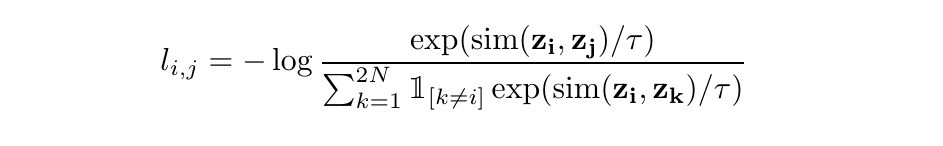

In [7]:
class NT_Xent(tf.keras.layers.Layer):
    """ Normalized temperature-scaled CrossEntropy loss [1]
        [1] T. Chen, S. Kornblith, M. Norouzi, and G. Hinton, “A simple framework for contrastive learning of visual representations,” arXiv. 2020, Accessed: Jan. 15, 2021. [Online]. Available: https://github.com/google-research/simclr.
    """
    def __init__(self, tau=1, **kwargs):
        super().__init__(**kwargs)
        self.tau = tau
        self.similarity = tf.keras.losses.CosineSimilarity(axis=-1, reduction=tf.keras.losses.Reduction.NONE)
        self.criterion = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        
    def get_config(self):
        return {"tau": self.tau}
        
    def call(self, zizj):
        """ zizj is [B,N] tensor with order z_i1 z_j1 z_i2 z_j2 z_i3 z_j3 ... 
            batch_size is twice the original batch_size
        """
        batch_size = tf.shape(zizj)[0]
        mask = tf.repeat(tf.repeat(~tf.eye(batch_size/2, dtype=tf.bool), 2, axis=0), 2, axis=1)

        sim = -1*self.similarity(tf.expand_dims(zizj, 1), tf.expand_dims(zizj, 0))/self.tau
        sim_i_j = -1*self.similarity(zizj[0::2], zizj[1::2])/self.tau

        pos = tf.reshape(tf.repeat(sim_i_j, repeats=2), (batch_size, -1))
        neg = tf.reshape(sim[mask], (batch_size, -1))

        logits = tf.concat((pos, neg), axis=-1)
        labels = tf.one_hot(tf.zeros((batch_size,), dtype=tf.int32), depth=batch_size-1)

        return self.criterion(labels, logits)


## Build Model

In [21]:
def build_model():

    # input_layer = layers.Input(shape=(None, None, 3))  # type: ignore
    # resizing = layers.Resizing(height=224, width=224)(input_layer)  # type: ignore
    # resnet = applications.ResNet50(weights='imagenet', include_top=False)(resizing)  # type: ignore

    # flattnen = layers.Flatten()(resnet.) # type: ignore
    # output = layers.Dense(10)(flattnen)


    # proejction head
    
    
    # model.add(layers.Dense(1024, activation='relu'))
    # model.add(layers.Dense(256, activation='relu'))

    # output layer
    # model.add(layers.Dense(1000, activation=activations.softmax))

    input_layer = layers.Input(shape=(None, None, 3))  # type: ignore
    resizing = layers.Resizing(height=224, width=224)(input_layer)  # type: ignore
    
    resnet50_imagenet_model = applications.ResNet50(
        include_top=True, weights='imagenet', input_shape=(224, 224, 3))(resizing)

    #Flatten output layer of Resnet
    flattened = tf.keras.layers.Flatten()(resnet50_imagenet_model)

    #Fully connected layer 1
    fc1 = tf.keras.layers.Dense(
        128, activation='relu', name="AddedDense1")(flattened)

    #Fully connected layer, output layer
    fc2 = tf.keras.layers.Dense(
        12, activation='softmax', name="AddedDense2")(fc1)

    return tf.keras.models.Model(
        inputs=input_layer, outputs=fc2)

    # return Model(inputs=input_layer, outputs=output, name="Model")


## Training

In [25]:
model = build_model()
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
num_epochs = 10
batch_size = 256
history = model.fit(x=train_ds,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(train_ds))


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 resizing_7 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 flatten_4 (Flatten)         (None, 1000)              0         
                                                                 
 AddedDense1 (Dense)         (None, 128)               128128    
                                                                 
 AddedDense2 (Dense)         (None, 12)                1548      
                                                                 
Total params: 25,766,388
Trainable params: 25,713,268
Non-t

AttributeError: module 'numpy' has no attribute 'expend_dims'

## t-SNE visualization

In [4]:
# NOTE: Work In Process
from sklearn import manifold, datasets
# X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X)

NameError: name 'X' is not defined